<p><i>A Simple Analysis of 2016 MLB Pitching Injuries</i></p> by Michael Klear

To complete my first capstone project for the Thinkful data science prep course, I reached out to my family email group for any ideas for a research topic. I recieved several suggestions but decided to pursue a sports-related topic because I know there is a lot of easy-to-access sports data available.


My cousin is curious about a correlation between pitchers' activity in one season and their being placed on the disabled list the next season. I'm going to take a look at injuries in 2016 and out volume (innings pitched times three) in 2015.


The number of innings pitched per season is a starting point but may be insufficient to quantify pitcher activity. Starting pitchers will appear in far more innings than the rest of the pitching staff, for example. I'll try to come up with a notion of a "normal" season for a given pitcher based on their career history to see if there's a correlation between a relatively busy season for a pitcher and appearing on the disabled list the next season.

I'd also like to see if there's a correlation for Tommy John surgeries in 2016 and prior activity as well.


The three questions I'd like to answer are:


(1) Is there a correlation between pitcher out volume in 2015 and their appearing on the disabled list in 2016?

(2) Is there a similar correlation for pitchers who appeared on the 2016 disabled list for Tommy John surgery?


(3) Is there a correlation between Tommy John surgeries in 2016 and pitcher out volume in 2014 (two seasons prior)?

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from datawrangler import format_names, reconcile_names, build_frame
import matplotlib.pyplot as plt
%matplotlib inline

The functions I wrote to help wrangle this data into a usable format (datawrangler.py) can be found at https://github.com/AlliedToasters/pitchers/blob/master/datawrangler.py.

I found a comprehensive list of pitcher information as a part of the exhaustive Lahman's Baseball Database set (http://www.seanlahman.com/baseball-archive/statistics/). It includes player stats dating back to 1871, which is really cool!

<b>Question 1: </b>

In [2]:
pitching_data = pd.read_csv('Pitching.csv')

To combine this information with injury data, I wrote the build_frame() function. It will gather the information I'm interested in, out volume in 2015, for pitchers in the Lahman database. 

To compare out volume in 2015 to a player's average out volume, it calculates the "normalized out volume." It's simply the ratio of out volume in 2015 to that pitcher's average out volume per season based on prior seasons. If 2015 if the pitcher's MLB debut, this value will be set to 1. 


All prior seasons will be compiled into totals: 

-number of prior seasons ("NoPS")

-outs pitched in prior seasons("PSOV")

-prior average out volume per season("OV/S")

-"normalized out volume" for 2015 ("NOV2015")

-A column will denote whether that player appeared on the disabled list in 2016 ("Inj2016")



In [3]:
df = build_frame(pitching_data)

Our dataframe looks like this:

In [4]:
df.head()

,PSOV,NoPS,OV/S,OV2015,NOV2015,Inj2016
hudsoda01,1152,5,230.4,203,0.881076,False
alberma01,1546,9,171.778,112,0.652005,False
davieky01,2304,7,329.143,7,0.0212674,False
morrobr01,2207,8,275.875,99,0.358858,False
kendrky01,3416,8,427,427,1,False


I collected the disabled list information for the 2015 and 2016 seasons from baseballheatmaps.com (http://www.baseballheatmaps.com/disabled-list-data/). For now, I'm going to include all pitchers who appeared on the disabled list regardless of the specific reason for disability.

In [5]:
inj2016 = pd.read_csv('2016_disabled_list.csv')
inj2016.head()

,Name,Season,Team,Position,on_DL,off_dl,days,Location,Injury Type,Side/Location,Location id,PlayerId,Teamid
0,A.J. Griffin,2016,Rangers,RHP,05/08/16,10/03/16,148,shoulder,stiffness,right,18,11132,13
1,A.J. Morris,2016,Reds,RHP,06/16/16,10/03/16,109,shoulder,strained,right,18,9919,18
2,A.J. Pierzynski,2016,Braves,C,08/17/16,09/01/16,15,hamstring,strained,left,5,746,16
3,A.J. Pierzynski,2016,Braves,C,09/11/16,10/03/16,22,hamstring,strained,NaN,5,746,16
4,A.J. Pollock,2016,Diamondbacks,CF,04/03/16,08/26/16,145,elbow,fractured,right,8,9256,15


This spreadsheet contains all players on the disabled list. We'll narrow them down to just pitchers (RHP and LHP, depending on handedness) and produce a list of those pitchers' names.

In [6]:
inj2016_names = list(inj2016[inj2016['Position'] == 'RHP'].Name) + list(inj2016[inj2016['Position'] == 'LHP'].Name)
inj2016_names = list(set(inj2016_names)) #remove duplicates, when player appears more than once on DL
print('The list contains {} names.'.format(len(inj2016_names)))

The list contains 276 names.


Now we have a list of the 276 pitchers on the 2016 disabled list. I made the format_names() function to format these names to the way they appear in the Lahman database.

One formatting anomaly is the player Rubby de la Rosa. He appears as "delarru01" in the Lahman set, but my formatter produces 'rosaru01'. I address that explicitly.

In [7]:
print('The names on the list came in this format: {}'.format(inj2016_names[0]))
inj2016_names = format_names(inj2016_names)
inj2016_names.remove('rosaru01')
inj2016_names.append('delarru01')
print('The names on the list now appear in this format: {}'.format(inj2016_names[0]))

The names on the list came in this format: Daniel Norris
The names on the list now appear in this format: norrida01


The numeral on the Lahman playerID changes if that playerID has appeared for a previous player. The reconcile_names() function matches the names on this list to names on our player dataframe. If it doesn't find the name, it will iterate through the numerals (0 to 99) until it finds a match. It will set that playerID with the appropriate numeral. If it doesn't find a match, it returns a list of names that were not found on the Lahman set.
These players did not appear in 2015 and therefore are not in our dataframe nor in the scope of this question. We'll remove them from our list.

In [8]:
inj2016_names, missing_players = reconcile_names(inj2016_names, df.index)
for player in missing_players:
    inj2016_names.remove(player)

print('{} names were removed from the list.'.format(len(missing_players)))
print('The injured group contains {} players.'.format(len(inj2016_names)))

45 names were not found.
45 names were removed from the list.
The injured group contains 231 players.


We mark the matched players as injured in the dataframe:

In [9]:
for name in inj2016_names:
    df.set_value(name, 'Inj2016', True)

Now we're ready to look at the numbers.

In [10]:
print('The mean out volume for 2015 (OV2015) for all pitchers was: {}'.format(df.OV2015.mean()))
print('The mean OV2015 for those uninjured in 2016 is: {}'.format(df[df['Inj2016'] == False].OV2015.mean()))
print('The mean OV2015 for those injured in 2016 is: {}'.format(df[df['Inj2016'] == True].OV2015.mean()))
print('\t')
print('The mean normalized out volume for 2015 (NOV2015) for all pitchers was: {}'.format(df.NOV2015.mean()))
print('The mean NOV2015 for those uninjured in 2016 is: {}'.format(df[df['Inj2016'] == False].NOV2015.mean()))
print('The mean NOV2015 for those injured in 2016 is: {}'.format(df[df['Inj2016'] == True].NOV2015.mean()))

The mean out volume for 2015 (OV2015) for all pitchers was: 177.17414965986396
The mean OV2015 for those uninjured in 2016 is: 153.4404761904762
The mean OV2015 for those injured in 2016 is: 228.95670995670994
	
The mean normalized out volume for 2015 (NOV2015) for all pitchers was: 1.4790707931057203
The mean NOV2015 for those uninjured in 2016 is: 1.2955288080657983
The mean NOV2015 for those injured in 2016 is: 1.8795260331928252


We have two groups. The first group ("Uninjured") contains the pitchers who appeared in 2015 and did not appear on the disabled list in 2016. The second group ("Injured") contains the pitchers who appeared in 2015 and did appear on the disable list in 2016.

The mean out volume for all pitchers in 2015 is 177 outs. For those injured, the mean out volume is 229 outs. For the uninjured, the mean out volume is 153 outs.

The mean normalied out volume in 2015 (NOV2015) for all pitchers is 1.48. The mean NOV2015 for those injured is 1.88 and the uninjured group is 1.30. 

So, by both metrics, the players who appeared on the disabled list in 2016 appear to have, on average, pitched more innings in 2015 than those who did not.


Let's look at the distribution of out volume within the two groups. The following plots are normalized, meaning the total number of players adds up to one for each group. This is important because the injured group is smaller than the uninjured group. This allows us to view the distribution of pitchers "apples to apples".

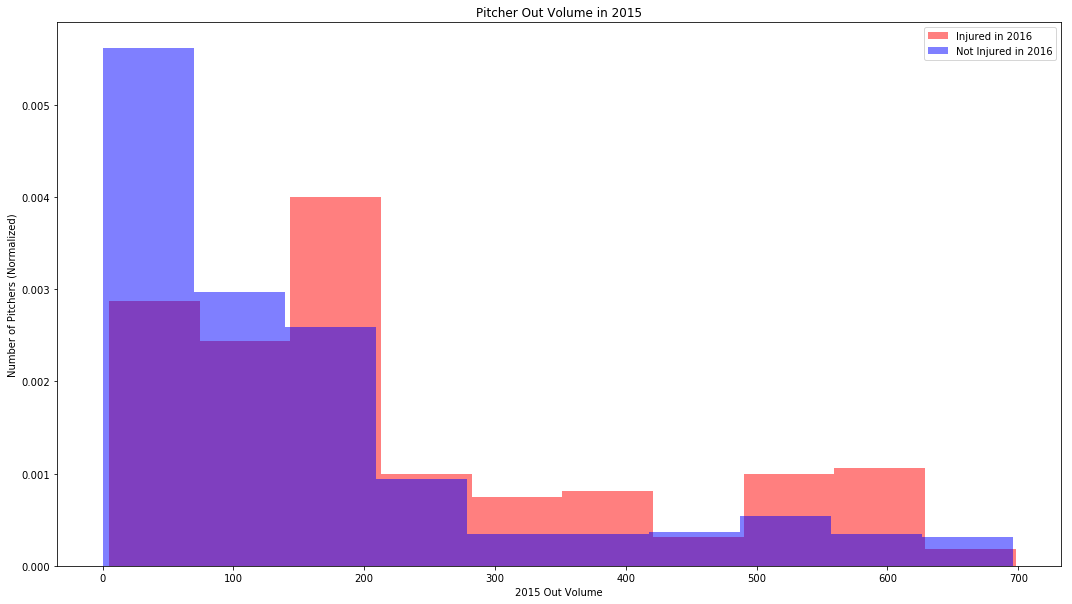

In [11]:
plt.figure(figsize=(18, 10));
plt.hist(df[df['Inj2016']==True].OV2015, color = 'r', alpha = .5, normed=True, label='Injured in 2016');
plt.hist(df[df['Inj2016']==False].OV2015, color = 'b', alpha = .5, normed=True, label='Not Injured in 2016');
plt.title('Pitcher Out Volume in 2015');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2015 Out Volume');
plt.legend();

Interestingly, the uninjured group seems to be concentrated at the lower end of the distribution while the injured group appears to be more evenly distributed among all out volumes. Importantly, it looks like the injured group tends to have pitched more outs than the uninjured group.

To look at NOV2015, it's important to note that there are a few very high NOV2015 values. I'm going to set any value higher than five equal to five, in the group "5 or more."

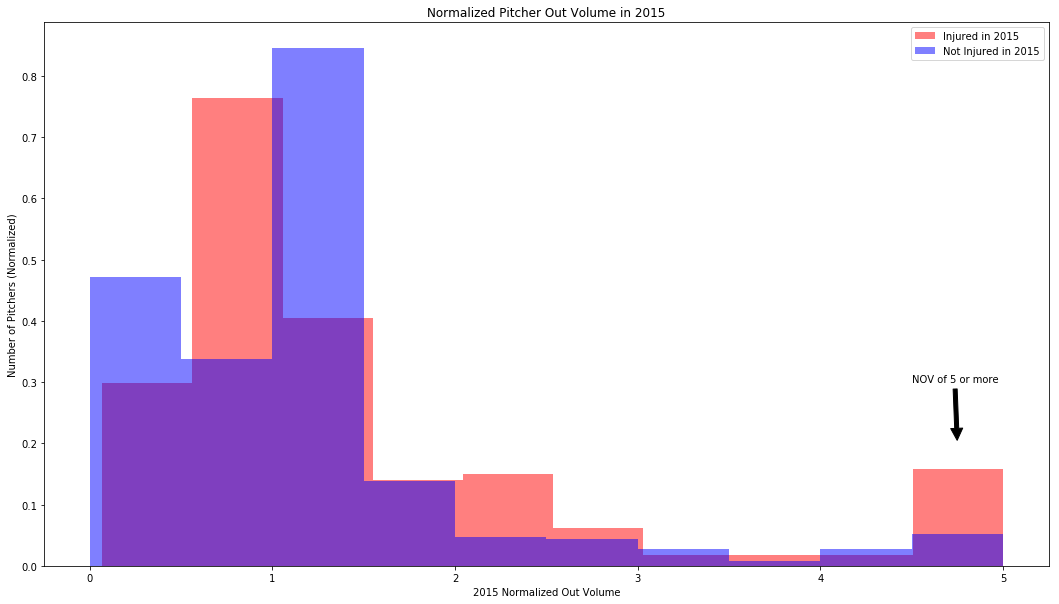

In [12]:
nov2015_inj = list(df[df['Inj2016']==True].NOV2015)
for i, val in enumerate(nov2015_inj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2015_inj[i] = 5
        
nov2015_uninj = list(df[df['Inj2016']==False].NOV2015)
for i, val in enumerate(nov2015_uninj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2015_uninj[i] = 5
        
fig = plt.figure(figsize=(18, 10));  
ax = fig.add_subplot(111)
plt.hist(nov2015_inj, color = 'r', alpha = .5, normed=True, label='Injured in 2015');
plt.hist(nov2015_uninj, color = 'b', alpha = .5, normed=True, label='Not Injured in 2015');
plt.title('Normalized Pitcher Out Volume in 2015');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2015 Normalized Out Volume');
ax.annotate('NOV of 5 or more', xy=(4.75, .2), xytext=(4.5, .3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.legend();

Notice how the "very high" NOV group (5 or greater) has many more injured players than uninjured. Other than that, the two distributions appear to be similar to each other.

To rigorously quantify these correlations, we'll apply the t-test. This calculates the likelihood that an apparent correlation would happen by random "noise" in our data.

In [13]:
print(ttest_ind(df[df['Inj2016']==True]['OV2015'], df[df['Inj2016']==False]['OV2015'], equal_var = False))
print(ttest_ind(df[df['Inj2016']==True]['NOV2015'], df[df['Inj2016']==False]['NOV2015'], equal_var = False))

Ttest_indResult(statistic=5.3496276345264411, pvalue=1.4630842233344046e-07)
Ttest_indResult(statistic=2.4133352609589869, pvalue=0.016315466493127703)


For non-normalized out volume, the t-statistic is greater than positive 5 an the p value is extremely small between the two groups. The t-statistic affirms that the mean out volume for the injured group is significantly higher than that of the non-injured group. The very small p-value of .0000001 tells us that there is a very small chance (.00001%) of this occuring randomly.

The normalized out volume (NOV2015) gives us a smaller t-statistic of 2.41 and larger p-value of .016. Usually, any p-value less than .05 is considered significant, so we can still see a positive correlation between injury in 2016 and out volume "normalized" against each player's specific career. However, the correlation here is not as strong as that seen with pure out volume.


For a sanity check, let's take a random sample of players from our dataframe and run the same test. If the distribution is "normal" enough, we would expect to see a p-value greater than .05 and a t-statistic with a magnitude smaller than 1. 

Our injured group size is 231, so we'll make our random sample the same size: 231 players.

In [14]:
df.Inj2016 = False
for name in df.sample(231).NOV2015.index:
    df.set_value(name, 'Inj2016', True)

In [15]:
print(ttest_ind(df[df['Inj2016']==True]['OV2015'], df[df['Inj2016']==False]['OV2015'], equal_var = False))
print(ttest_ind(df[df['Inj2016']==True]['NOV2015'], df[df['Inj2016']==False]['NOV2015'], equal_var = False))

Ttest_indResult(statistic=2.0641819521985263, pvalue=0.039651261771553363)
Ttest_indResult(statistic=0.30403013406654539, pvalue=0.76121848251552904)


When we run the same test with this random sample, we see that, as expected, we get high p-values (close to 1) and low t-statistics. We would expect similar results for the group that was actually injured in 2016 if there were no correlation between out volume in 2015 and disability in 2016 (the null hypothesis.) 

Because of our high t-statistics and low p-values, we can reject the null hypothesis and rigorously support a positive correlation between out volume in 2015 and disability in 2016.

<b>Question 2:</b>

Now let's narrow our scope to just Tommy John surgery. This is an invasive surgery that takes months out of a pitcher's career, often forcing them to miss an entire season. It's one that coaches and players alike would like to avoid.

Our injured group this time around will include those players who appeared on the disabled list in 2016 with "Tommy John surgery" as the reason for disability, and uninjured will be all other players who appeared in 2015.

In [16]:
df.Inj2016 = False

In [17]:
tj2016 = inj2016[inj2016['Injury Type'] == 'Tommy John surgery']

In [18]:
tj_names = list(tj2016.Name)
tj_names = list(set(tj_names)) #Remove any duplicates
tj_names = format_names(tj_names)
tj_names, missing_players = reconcile_names(tj_names, df.index)
for player in missing_players:
    tj_names.remove(player)
print('{} names have been removed from the list.'.format(len(missing_players)))
print('The injured group contains {} players.'.format(len(tj_names)))

11 names were not found.
11 names have been removed from the list.
The injured group contains 11 players.


We can see that this is a much smaller group of 22 players, only 11 of whom appeared in 2015. We'll mark them as injured in our dataframe:

In [19]:
df.Inj2016 = False
for name in tj_names:
    df.set_value(name, 'Inj2016', True)

Let's take a look at the numbers:

In [20]:
print('The mean out volume for 2015 (OV2015) for all pitchers was: {}'.format(df.OV2015.mean()))
print('The mean OV2015 for those not disabled due to Tommy John surgery in 2016 is: {}'.format(df[df['Inj2016'] == False].OV2015.mean()))
print('The mean OV2015 for those disabled due to Tommy John surgery in 2016 is: {}'.format(df[df['Inj2016'] == True].OV2015.mean()))
print('\t')
print('The mean normalized out volume for 2015 (NOV2015) for all pitchers was: {}'.format(df.NOV2015.mean()))
print('The mean NOV2015 for those not disabled for Tommy John surgery in 2016 is: {}'.format(df[df['Inj2016'] == False].NOV2015.mean()))
print('The mean NOV2015 for those disabled for Tommy John surgery in 2016 is: {}'.format(df[df['Inj2016'] == True].NOV2015.mean()))

The mean out volume for 2015 (OV2015) for all pitchers was: 177.17414965986396
The mean OV2015 for those not disabled due to Tommy John surgery in 2016 is: 178.189226519337
The mean OV2015 for those disabled due to Tommy John surgery in 2016 is: 110.36363636363636
	
The mean normalized out volume for 2015 (NOV2015) for all pitchers was: 1.4790707931057203
The mean NOV2015 for those not disabled for Tommy John surgery in 2016 is: 1.4888904704339077
The mean NOV2015 for those disabled for Tommy John surgery in 2016 is: 0.8327574853232208


In this case, we see that the 2015 mean out volume and normalized out volume for 2015 for the injured group is actually smaller than those for all pitchers and for the "uninjured" group. Since the injured group is so tiny, the set of all pitchers is almost identical to the "uninjured" group.

Let's visualized these distributions. As before, we'll normalize these distributions so we can compare them qualitatively.

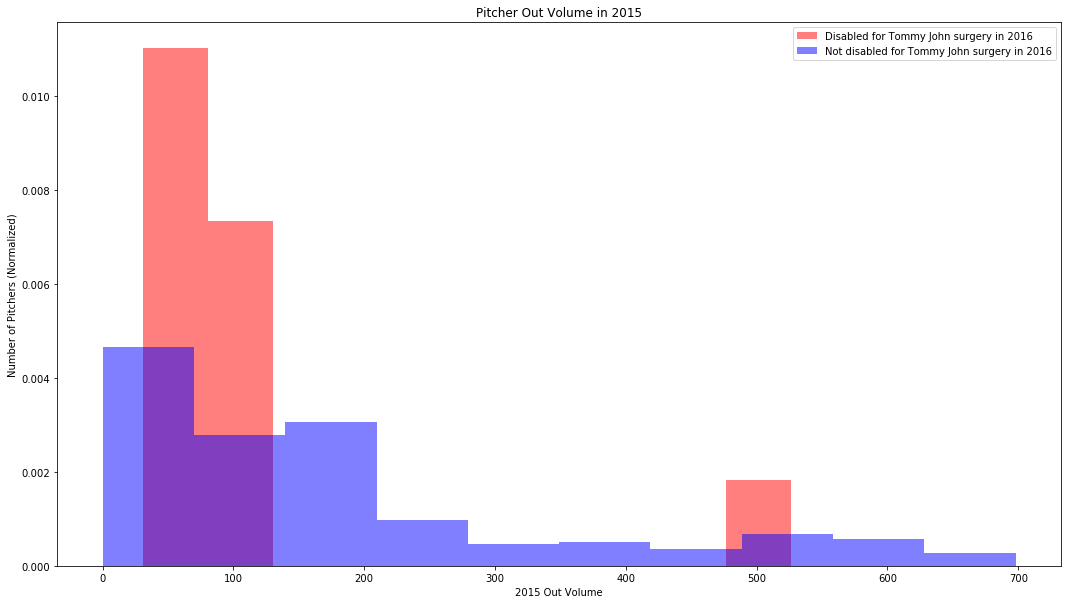

In [21]:
plt.figure(figsize=(18, 10));
plt.hist(df[df['Inj2016']==True].OV2015, color = 'r', alpha = .5, normed=True, label='Disabled for Tommy John surgery in 2016');
plt.hist(df[df['Inj2016']==False].OV2015, color = 'b', alpha = .5, normed=True, label='Not disabled for Tommy John surgery in 2016');
plt.title('Pitcher Out Volume in 2015');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2015 Out Volume');
plt.legend();

The small size of our surgery group shows itself here. However, they mostly appear to have pitched less innings in 2015 than the non-Tommy-John-surgery group.

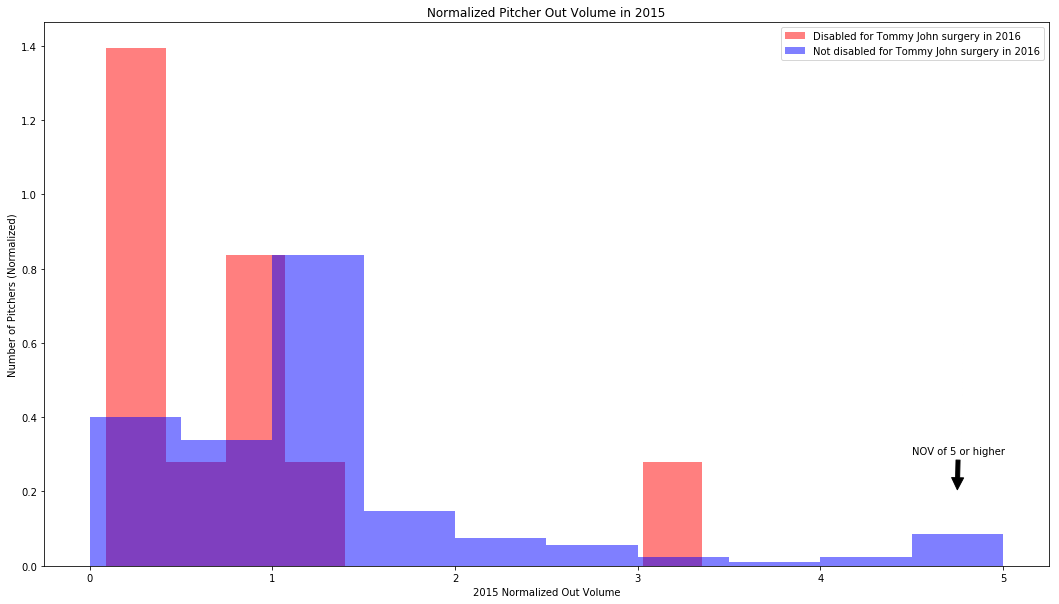

In [22]:
nov2015_inj = list(df[df['Inj2016']==True].NOV2015)
for i, val in enumerate(nov2015_inj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2015_inj[i] = 5
        
nov2015_uninj = list(df[df['Inj2016']==False].NOV2015)
for i, val in enumerate(nov2015_uninj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2015_uninj[i] = 5
        
fig = plt.figure(figsize=(18, 10));  
ax = fig.add_subplot(111)
plt.hist(nov2015_inj, color = 'r', alpha = .5, normed=True, label='Disabled for Tommy John surgery in 2016');
plt.hist(nov2015_uninj, color = 'b', alpha = .5, normed=True, label='Not disabled for Tommy John surgery in 2016');
plt.title('Normalized Pitcher Out Volume in 2015');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2015 Normalized Out Volume');
ax.annotate('NOV of 5 or higher', xy=(4.75, .2), xytext=(4.5, .3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.legend();

Notice that none of the pitchers who were disabled due to Tommy John surgery in 2016 pitched more than four times their average season's worth of outs in 2015.

We can see that the concentration of those in Tommy John surgery group are lower in both visualizations. Let's apply the t-test.

In [23]:
print(ttest_ind(df[df['Inj2016']==True]['OV2015'], df[df['Inj2016']==False]['OV2015'], equal_var = False))
print(ttest_ind(df[df['Inj2016']==True]['NOV2015'], df[df['Inj2016']==False]['NOV2015'], equal_var = False))

Ttest_indResult(statistic=-1.5837520187534455, pvalue=0.1429550725670089)
Ttest_indResult(statistic=-2.2153370671432433, pvalue=0.045292088130213751)


When we apply the t-test, we get fairly high p-values for both out volume and normalized out volume. This is likely in part due to our small sample size. With only 11 data points, the chance of "seeing" a correlation due to random noise in the data is higher. However, the negative t-statistic with a magnitude greater than one for both suggests that there may be a negative correlation. That is, the players listed as disabled due to Tommy John surgery in 2016 tend to have pitched less innings in 2015. For normalized out volume, the p-value is just below .05, which could be considered a significant negative correlation.

This result contradicts our investigation of my first question, but it makes sense. Tommy John surgery is preceded by other complications and injuries. That means it's very likely that these players missed games in 2015 due to these complications which would lower their out volume.

Let's go back another season and look at this same group of injured pitchers and their out volume in 2014.

<b> Question 3: </b>

We'll build a similar dataframe, this time with 2014 numbers rather than 2015.

In [24]:
df14 = build_frame(pitching_data, 2014)

Our dataframe looks like this:

In [25]:
df14.head()

,PSOV,NoPS,OV/S,OV2014,NOV2014,Inj2016
hudsoda01,1144,4,286,8,0.027972,False
alberma01,1516,8,189.5,30,0.158311,False
morrobr01,2107,7,301,100,0.332226,False
kendrky01,2819,7,402.714,597,1.48244,False
hellije01,1729,4,432.25,191,0.441874,False


Let's generate our list of injured players again:

In [26]:
tj2016 = inj2016[inj2016['Injury Type'] == 'Tommy John surgery']
tj_names = list(tj2016.Name)
tj_names = list(set(tj_names)) #Remove any duplicates
tj_names = format_names(tj_names)
tj_names, missing_players = reconcile_names(tj_names, df14.index)
len(tj_names)
for player in missing_players:
    tj_names.remove(player)
print('{} names have been removed from the list.'.format(len(missing_players)))
print('The injured group contains {} players.'.format(len(tj_names)))

5 names were not found.
5 names have been removed from the list.
The injured group contains 17 players.


Notice that, of the 22 players listed as disabled for Tommy John surgery in 2016, 17 appeared in 2014. Only 11 appeared in 2015.

We'll flag these players as injured in our dataframe:

In [27]:
for name in tj_names:
    df14.set_value(name, 'Inj2016', True)

And look at the numbers:

In [28]:
print('The mean out volume for 2014 (OV2014) for all pitchers was: {}'.format(df14.OV2014.mean()))
print('The mean OV2014 for those not disabled for Tommy John surgery in 2016 is: {}'.format(df14[df14['Inj2016'] == False].OV2014.mean()))
print('The mean OV2014 for those disabled for Tommy John surgery in 2016 is: {}'.format(df14[df14['Inj2016'] == True].OV2014.mean()))
print('\t')
print('The mean normalized out volume for 2014 (NOV2014) for all pitchers was: {}'.format(df14.NOV2014.mean()))
print('The mean NOV2014 for those not disabled for Tommy John surgery in 2016 is: {}'.format(df14[df14['Inj2016'] == False].NOV2014.mean()))
print('The mean NOV2014 for those disabled for Tommy John surgery in 2016 is: {}'.format(df14[df14['Inj2016'] == True].NOV2014.mean()))

The mean out volume for 2014 (OV2014) for all pitchers was: 189.07658959537574
The mean OV2014 for those not disabled for Tommy John surgery in 2016 is: 186.53333333333333
The mean OV2014 for those disabled for Tommy John surgery in 2016 is: 290.05882352941177
	
The mean normalized out volume for 2014 (NOV2014) for all pitchers was: 1.325987481386519
The mean NOV2014 for those not disabled for Tommy John surgery in 2016 is: 1.329306920657702
The mean NOV2014 for those disabled for Tommy John surgery in 2016 is: 1.1941862162071877


When we look at the 2014, we see that those disabled for Tommy John surgery in 2016 have a much higher mean out volume (290) in 2014 than the other group (187). The mean NOV2014 for this group (1.19), however, is lower than the other group (1.33). 

Let's look at the distributions:

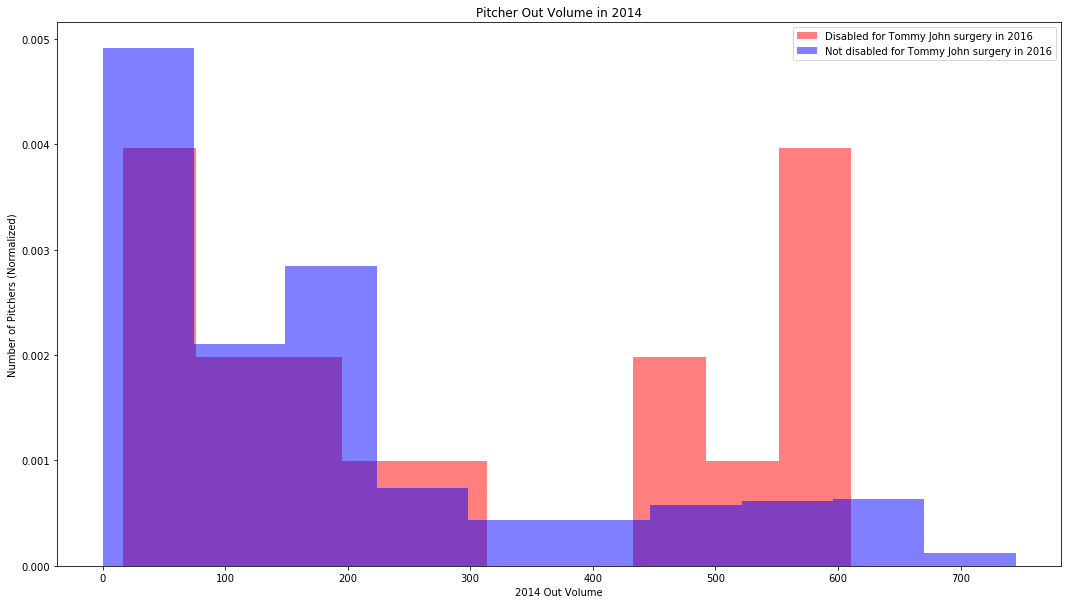

In [29]:
plt.figure(figsize=(18, 10));
plt.hist(df14[df14['Inj2016']==True].OV2014, color = 'r', alpha = .5, normed=True, label='Disabled for Tommy John surgery in 2016');
plt.hist(df14[df14['Inj2016']==False].OV2014, color = 'b', alpha = .5, normed=True, label='Not disabled for Tommy John surgery in 2016');
plt.title('Pitcher Out Volume in 2014');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2014 Out Volume');
plt.legend();

Notice the high concentration of our Tommy John group pitching a high number of outs (between 450 and 600) in 2014.

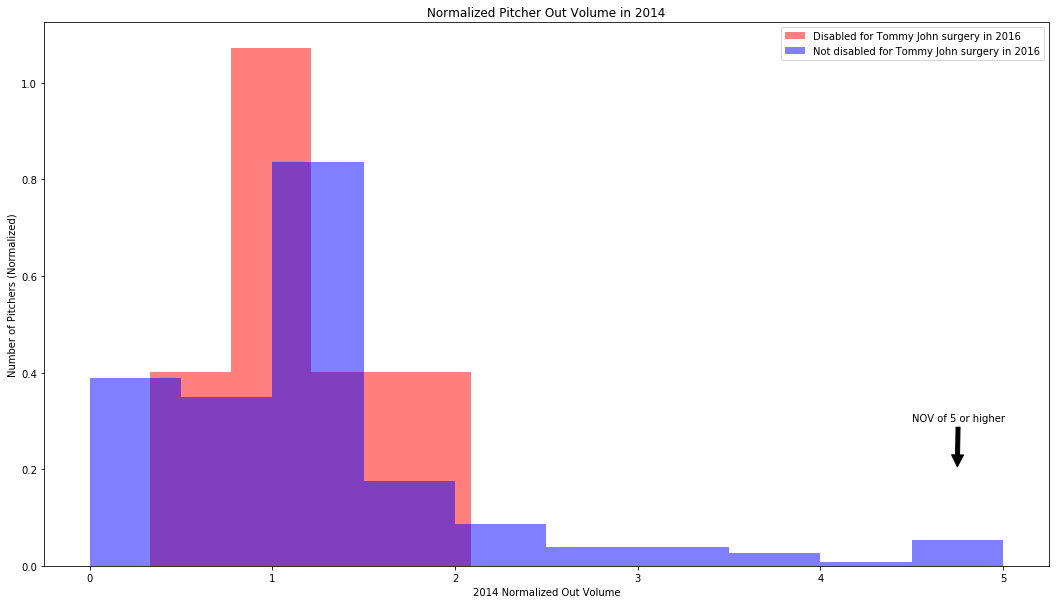

In [30]:
nov2014_inj = list(df14[df14['Inj2016']==True].NOV2014)
for i, val in enumerate(nov2014_inj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2014_inj[i] = 5
        
nov2014_uninj = list(df14[df14['Inj2016']==False].NOV2014)
for i, val in enumerate(nov2014_uninj): #Set anything greater than 5 to 5.
    if val > 5:
        nov2014_uninj[i] = 5
        
fig = plt.figure(figsize=(18, 10));  
ax = fig.add_subplot(111)
plt.hist(nov2014_inj, color = 'r', alpha = .5, normed=True, label='Disabled for Tommy John surgery in 2016', bins=4);
plt.hist(nov2014_uninj, color = 'b', alpha = .5, normed=True, label='Not disabled for Tommy John surgery in 2016');
plt.title('Normalized Pitcher Out Volume in 2014');
plt.ylabel('Number of Pitchers (Normalized)');
plt.xlabel('2014 Normalized Out Volume');
ax.annotate('NOV of 5 or higher', xy=(4.75, .2), xytext=(4.5, .3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.legend();

The normalized out volume for this injured group does not exceed 3.

These distributions seem to suggest a higher out volume in 2014 for the group that ended up disabled for Tommy John surgery in 2016. However, due to the small sample size, our t-tests are still inconclusive:

In [31]:
print(ttest_ind(df14[df14['Inj2016']==True]['OV2014'], df14[df14['Inj2016']==False]['OV2014'], equal_var = False))
print(ttest_ind(df14[df14['Inj2016']==True]['NOV2014'], df14[df14['Inj2016']==False]['NOV2014'], equal_var = False))

Ttest_indResult(statistic=1.942437900982964, pvalue=0.069256894578068537)
Ttest_indResult(statistic=-0.96816337049765733, pvalue=0.3409458333413905)


With no p-value below .05, it's impossible to reject the null hypothesis. This can be due to our small sample size. However, the high t-statistic of almost 2 and p-value of .07 for total out volume in 2014 leaves the possibility open for this correlation. We'd need to compile more data for Tommy John surgeries over many years to pin this one down.

<b>Conclusion</b>

The strong correlation we found in this study was between out volume (both normalized and nominal) in 2015 and appearances on the disabled list in 2016. When we looked specifically at disability due to Tommy John surgery in 2016, there is no statistically significant correlation. This appears to be due to a small sample size, so these two questions are still open to further research.

The one strong correlation I found here suggests that coaches should try to keep their pitcher's absolute out volume lower and keep their out volume close to that pitcher's average seasonal out volume to lower that the chances of being disabled the next season. This would be especially true if that team is planning to contract or has contracted that particular pitcher for future seasons.